In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal
import copy

import random

os.chdir("/oak/stanford/groups/jamesz/abuen/spatial-sc/repos/spatial-gnn/scripts")
from aging_gnn_model import *

import networkx as nx

import torch
import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import k_hop_subgraph, one_hot, to_networkx
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, SAGEConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.modules.loss import _Loss
from torch.distributions import MultivariateNormal as MVN

from sklearn.metrics import r2_score

In [2]:
celltypes_to_index = {
         'Neuron-Excitatory' : 0,
         'Neuron-Inhibitory' : 1,
         'Neuron-MSN' : 2, 
         'Astrocyte' : 3, 
         'Microglia' : 4, 
         'Oligodendrocyte' : 5, 
         'OPC' : 6,
         'Endothelial' : 7, 
         'Pericyte' : 8, 
         'VSMC' : 9, 
         'VLMC' : 10,
         'Ependymal' : 11, 
         'Neuroblast' : 12, 
         'NSC' : 13,  
         'Macrophage' : 14, 
         'Neutrophil' : 15,
         'T cell' : 16, 
         'B cell' : 17,
        }

## Predict gene expression

In [3]:

import json 

def load_dataset_config():
    """Load dataset configurations from JSON file."""
    config_path = "/oak/stanford/groups/jamesz/abuen/spatial-sc/repos/spatial-gnn/config/datasets.json"
    try:
        with open(config_path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset configuration file not found at {config_path}")
    except json.JSONDecodeError:
        raise ValueError(f"Invalid JSON format in dataset configuration file at {config_path}")

DATASET_CONFIGS = load_dataset_config()
dataset_config = DATASET_CONFIGS["aging_coronal"]

train_ids = dataset_config["train_ids"]
test_ids = dataset_config["test_ids"]

In [8]:
# get params
k_hop = 2
augment_hop = 2
center_celltypes = ["T cell","NSC","Pericyte"]
node_feature = "expression"
loss = "weightedl1"
learning_rate = 0.0001
use_model = "model"
#use_model = "best_model"
inject_feature = "center_celltype"
inject=False

#--------------------------------------------------------------

if inject is False:
    inject_feature = None

raw_filepaths = ["/oak/stanford/groups/jamesz/abuen/spatial-sc/data/raw/aging_coronal.h5ad"]

# init test data
test_dataset = SpatialAgingCellDataset(subfolder_name="test",
                                       target="expression",
                                       k_hop=k_hop,
                                       augment_hop=augment_hop,
                                       node_feature=node_feature,
                                       inject_feature=inject_feature,
                                       num_cells_per_ct_id=100,
                                       center_celltypes=center_celltypes,
                                  use_ids=test_ids,
                                  raw_filepaths=raw_filepaths)

# init train data
train_dataset = SpatialAgingCellDataset(subfolder_name="train",
                                        target="expression",
                                        k_hop=k_hop,
                                        augment_hop=augment_hop,
                                        node_feature=node_feature,
                                        inject_feature=inject_feature,
                                        num_cells_per_ct_id=100,
                                        center_celltypes=center_celltypes,
                                use_ids=train_ids,
                                raw_filepaths=raw_filepaths)

# concatenate datasets
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# define data loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
all_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# LOAD MODELS
model_dirname = loss+f"_{learning_rate:.0e}".replace("-","n")
save_dir = os.path.join("results/gnn",train_dataset.processed_dir.split("/")[-2],model_dirname)
save_dir = "/oak/stanford/groups/jamesz/abuen/spatial-sc/repos/spatial-gnn/bash/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject"

# TRAIN MODEL
# init model
if inject is True:
    model = GNN(hidden_channels=64,
                input_dim=int(train_dataset.get(0).x.shape[1]),
                output_dim=len(train_dataset.get(0).y), # added for multivariate targets
                inject_dim=int(train_dataset.get(0).inject.shape[1]), # added for injecting features into last layer (after pooling)
                method="GIN", pool="add", num_layers=k_hop)
else:
    model = GNN(hidden_channels=64,
            input_dim=int(train_dataset.get(0).x.shape[1]),
            output_dim=len(train_dataset.get(0).y), # added for multivariate targets
            method="GIN", pool="add", num_layers=k_hop)

# load model weights
model.load_state_dict(torch.load(os.path.join(save_dir, f"{use_model}.pth"),
                                map_location=torch.device('cpu')))

# # ALL MODEL
# # init model
# all_model = GNN(hidden_channels=16,
#             input_dim=int(test_dataset.get(0).x.shape[1]),
#             method="GIN", pool="add", num_layers=k_hop)

# # load model weights
# all_model.load_state_dict(torch.load(os.path.join(save_dir, f"all_{use_model}.pth")))

from torch_geometric import profile
profile.count_parameters(model)

FileNotFoundError: [Errno 2] No such file or directory: '/oak/stanford/groups/jamesz/abuen/spatial-sc/repos/spatial-gnn/bash/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/model.pth'

In [5]:
test_dataset

SpatialAgingCellDataset(15775)

In [6]:
train_dataset

SpatialAgingCellDataset(61593)

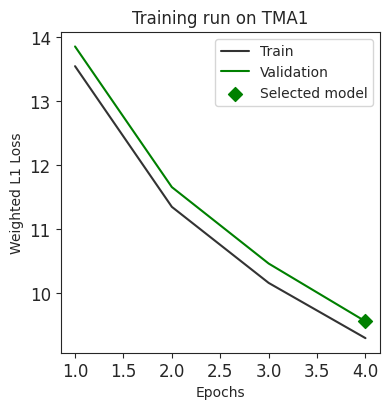

In [7]:
# load results
with open(os.path.join(save_dir, "training.pkl"), 'rb') as handle:
    b = pickle.load(handle)
    
# plot training/validation loss curves

best_idx = np.argmin(b['test'])

plt.figure(figsize=(4,4))
plt.plot(b['epoch'],b['train'],label='Train',color='0.2',zorder=0)
plt.plot(b['epoch'],b['test'],label='Validation',color='green',zorder=1)
plt.scatter(b['epoch'][best_idx],b['test'][best_idx],s=50,c='green',marker="D",zorder=2,label="Selected model")
plt.ylabel("Weighted L1 Loss")
plt.xlabel("Epochs")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.title("Training run on TMA1")
# plt.savefig(f"plots/gnn/{test_dataset.processed_dir.split('/')[-2]}_losscurves.pdf",
#             bbox_inches='tight')
plt.show()

# Model Evaluation

In [24]:
# make test predictions

model.eval()

preds = []
actuals = []
celltypes = []

for data in test_loader:
    
    if inject is False:
        out = model(data.x, data.edge_index, data.batch, None)
    else:
        out = model(data.x, data.edge_index, data.batch, data.inject)
    
    preds.append(out)
    
    if data.y.shape != out.shape:
        actuals.append(torch.reshape(data.y.float(), out.shape))
    else:
        actuals.append(data.y.float())

#     if inject is True: # i.e. if cell type is used for center cell // otherwise need to use center_node to get cell type

#         cct_mat = data.inject.numpy()

#         for i in range(cct_mat.shape[0]):
#             ct_idx = np.where(cct_mat[i,:]==1)[0][0]
#             celltypes.append(list(celltypes_to_index.keys())[ct_idx])

    # get cell type
    celltypes = np.concatenate((celltypes,np.concatenate(data.center_celltype)))
    
preds = np.concatenate([pred.detach().numpy() for pred in preds])
actuals = np.concatenate([act.detach().numpy() for act in actuals])

celltypes = np.array(celltypes)

In [25]:
# GENE STATS
gene_r = []
gene_s = []
gene_r2 = []
gene_mae = []
gene_rmse = []

for g in range(preds.shape[1]):
    
    r, p = pearsonr(preds[:,g], actuals[:,g])
    gene_r.append(r)
    
    s, p = spearmanr(preds[:,g], actuals[:,g])
    gene_s.append(s)
    
    r2 = r2_score(actuals[:,g], preds[:,g])
    gene_r2.append(r2)
    
    gene_mae.append(np.mean(np.abs(preds[:,g]-actuals[:,g])))
    gene_rmse.append(np.sqrt(np.mean((preds[:,g]-actuals[:,g])**2)))
    

# CELL STATS
cell_r = []
cell_s = []
cell_r2 = []
cell_mae = []
cell_rmse = []

for c in range(preds.shape[0]):
    
    r, p = pearsonr(preds[c,:], actuals[c,:])
    cell_r.append(r)
    
    s, p = spearmanr(preds[c,:], actuals[c,:])
    cell_s.append(s)
    
    r2 = r2_score(actuals[c,:], preds[c,:])
    cell_r2.append(r2)
    
    cell_mae.append(np.mean(np.abs(preds[c,:]-actuals[c,:])))
    cell_rmse.append(np.sqrt(np.mean((preds[c,:]-actuals[c,:])**2)))

In [26]:
# drop genes that are missing everywhere
preds = preds[:, actuals.max(axis=0)>=0]
actuals = actuals[:, actuals.max(axis=0)>=0]

In [27]:
# GENE STATS -- NON-NEGATIVE ONLY
gene_r = []
gene_s = []
gene_r2 = []
gene_mae = []
gene_rmse = []

for g in range(preds.shape[1]):
    
    r, p = pearsonr(preds[actuals[:,g]>=0,g], actuals[actuals[:,g]>=0,g])
    gene_r.append(r)
    
    s, p = spearmanr(preds[actuals[:,g]>=0,g], actuals[actuals[:,g]>=0,g])
    gene_s.append(s)
    
    r2 = r2_score(actuals[actuals[:,g]>=0,g], preds[actuals[:,g]>=0,g])
    gene_r2.append(r2)
    
    gene_mae.append(np.mean(np.abs(preds[actuals[:,g]>=0,g]-actuals[actuals[:,g]>=0,g])))
    gene_rmse.append(np.sqrt(np.mean((preds[actuals[:,g]>=0,g]-actuals[actuals[:,g]>=0,g])**2)))
    

# CELL STATS -- NON-NEGATIVE ONLY
cell_r = []
cell_s = []
cell_r2 = []
cell_mae = []
cell_rmse = []

for c in range(preds.shape[0]):
    
    r, p = pearsonr(preds[c,actuals[c,:]>=0], actuals[c,actuals[c,:]>=0])
    cell_r.append(r)
    
    s, p = spearmanr(preds[c,actuals[c,:]>=0], actuals[c,actuals[c,:]>=0])
    cell_s.append(s)
    
    r2 = r2_score(actuals[c,actuals[c,:]>=0], preds[c,actuals[c,:]>=0])
    cell_r2.append(r2)
    
    cell_mae.append(np.mean(np.abs(preds[c,actuals[c,:]>=0]-actuals[c,actuals[c,:]>=0])))
    cell_rmse.append(np.sqrt(np.mean((preds[c,actuals[c,:]>=0]-actuals[c,actuals[c,:]>=0])**2)))

In [24]:
# save gene stats dataframe
df_gene = pd.DataFrame(np.vstack((gene_r, gene_s, gene_r2, gene_mae, gene_rmse)).T,
                       columns=["Pearson","Spearman","R2","MAE", "RMSE"])
df_gene.to_csv(os.path.join(save_dir, "test_evaluation_stats_gene.csv"), index=False)

# save cell stats dataframe
df_cell = pd.DataFrame(np.vstack((cell_r, cell_s, cell_r2, cell_mae, cell_rmse)).T,
                       columns=["Pearson","Spearman","R2","MAE", "RMSE"])
df_cell.to_csv(os.path.join(save_dir, "test_evaluation_stats_cell.csv"), index=False)

In [28]:
df_cell.median(axis=0)

NameError: name 'df_cell' is not defined

In [ ]:
df_gene.median(axis=0)

In [29]:
# stats broken down by cell type

ct_stats_dict = {}

for ct in np.unique(celltypes):
    
    ct_stats_dict[ct] = {}

    # GENE STATS
    gene_r = []
    gene_s = []
    gene_r2 = []
    gene_mae = []
    gene_rmse = []

    for g in range(preds.shape[1]):

        r, p = pearsonr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
        gene_r.append(r)

        s, p = spearmanr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
        gene_s.append(s)

        r2 = r2_score(actuals[celltypes==ct,g], preds[celltypes==ct,g])
        gene_r2.append(r2)

        gene_mae.append(np.mean(np.abs(preds[celltypes==ct,g]-actuals[celltypes==ct,g])))
        gene_rmse.append(np.sqrt(np.mean((preds[celltypes==ct,g]-actuals[celltypes==ct,g])**2)))


    # CELL STATS
    cell_r = []
    cell_s = []
    cell_r2 = []
    cell_mae = []
    cell_rmse = []

    for c in np.where(celltypes==ct)[0]:

        r, p = pearsonr(preds[c,:], actuals[c,:])
        cell_r.append(r)

        s, p = spearmanr(preds[c,:], actuals[c,:])
        cell_s.append(s)

        r2 = r2_score(actuals[c,:], preds[c,:])
        cell_r2.append(r2)

        cell_mae.append(np.mean(np.abs(preds[c,:]-actuals[c,:])))
        cell_rmse.append(np.sqrt(np.mean((preds[c,:]-actuals[c,:])**2)))

        pred_ct = celltypes==ct
        
    # add results to dictionary
    ct_stats_dict[ct]["Gene - Pearson (mean)"] = np.mean(gene_r)
    ct_stats_dict[ct]["Gene - Pearson (median)"] = np.median(gene_r)
    ct_stats_dict[ct]["Gene - Spearman (mean)"] = np.mean(gene_s)
    ct_stats_dict[ct]["Gene - Spearman (median)"] = np.mean(gene_s)
    ct_stats_dict[ct]["Gene - R2 (mean)"] = np.mean(gene_r2)
    ct_stats_dict[ct]["Gene - R2 (median)"] = np.mean(gene_r2)
    ct_stats_dict[ct]["Gene - MAE (mean)"] = np.mean(gene_mae)
    ct_stats_dict[ct]["Gene - RMSE (mean)"] = np.mean(gene_rmse)
    
    ct_stats_dict[ct]["Cell - Pearson (mean)"] = np.mean(cell_r)
    ct_stats_dict[ct]["Cell - Pearson (median)"] = np.median(cell_r)
    ct_stats_dict[ct]["Cell - Spearman (mean)"] = np.mean(cell_s)
    ct_stats_dict[ct]["Cell - Spearman (median)"] = np.mean(cell_s)
    ct_stats_dict[ct]["Cell - R2 (mean)"] = np.mean(cell_r2)
    ct_stats_dict[ct]["Cell - R2 (median)"] = np.median(cell_r2)
    ct_stats_dict[ct]["Cell - MAE (mean)"] = np.mean(cell_mae)
    ct_stats_dict[ct]["Cell - RMSE (mean)"] = np.mean(cell_rmse)

/tmp/ipykernel_91183/3458012676.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
/tmp/ipykernel_91183/3458012676.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s, p = spearmanr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
/tmp/ipykernel_91183/3458012676.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
/tmp/ipykernel_91183/3458012676.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s, p = spearmanr(preds[celltypes==ct,g], actuals[celltypes==ct,g])
/tmp/ipykernel_91183/3458012676.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(preds[celltypes==ct,g], actuals[celltypes==

In [30]:
with open(os.path.join(save_dir, "test_evaluation_stats_bycelltype.pkl"), 'wb') as f:
    pickle.dump(ct_stats_dict, f)

[None]

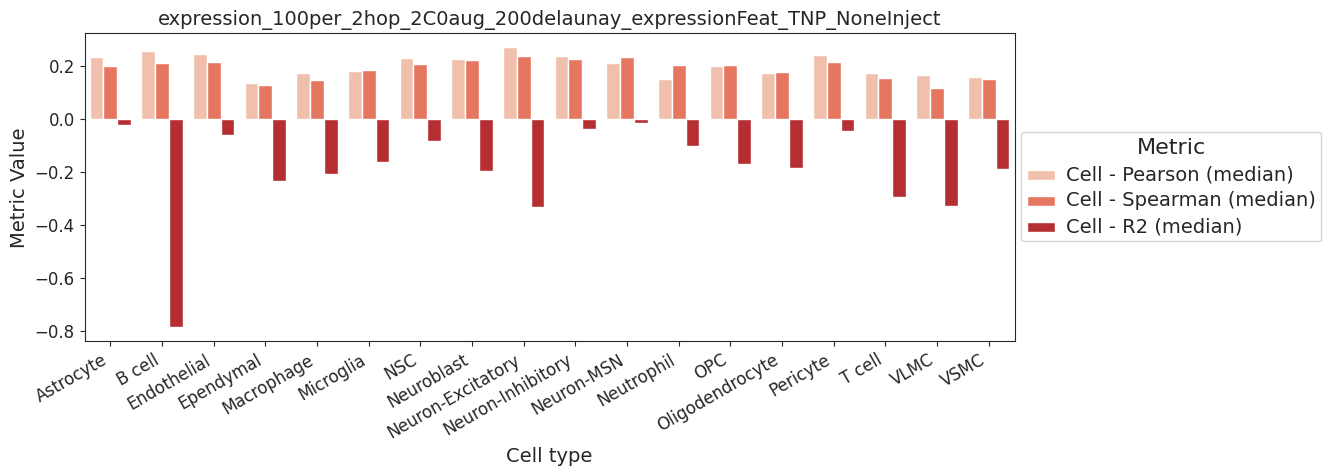

In [31]:
# Plot cell type performances

with open(os.path.join(save_dir, "test_evaluation_stats_bycelltype.pkl"), 'rb') as handle:
    ct_stats_dict = pickle.load(handle)

columns_to_plot = ["Cell - Pearson (median)", "Cell - Spearman (median)", "Cell - R2 (median)"]
    
#--------------------------------
metric_col = []
ct_col = []
val_col = []

for col in columns_to_plot:
    for ct in ct_stats_dict.keys():
        val = ct_stats_dict[ct][col]
        
        metric_col.append(col)
        ct_col.append(ct)
        val_col.append(val)

plot_df = pd.DataFrame(np.vstack((metric_col, ct_col, val_col)).T, columns=["Metric","Cell type","Value"])
plot_df["Value"] = plot_df["Value"].astype(float)

# plot
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(plot_df, x="Cell type", y="Value", hue="Metric", palette="Reds", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Cell type", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')


In [ ]:
# Plot cell type performances

columns_to_plot = ["Gene - Pearson (median)", "Gene - Spearman (median)", "Gene - R2 (median)"]
    
plot_df["Value"] = plot_df["Value"].astype(float)

# plot
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(plot_df, x="Cell type", y="Value", hue="Metric", palette="Reds", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Cell type", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.tight_layout()
plt.show()

# Perturbation Modeling Figures

## Subgraph steering validation

In [ ]:
# filename = "batch_steer_mean_10steps_test_actualtarget"
# filename = "batch_steer_mean_10steps_test_predictedtarget"

filename = "batch_steer_cell_10steps_test_actualtarget"
# filename = "batch_steer_cell_10steps_test_predictedtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
# Matched differences
pearson_diffs = stats_df[stats_df["Type"]=="Perturbed"]["Pearson"].values - stats_df[stats_df["Type"]=="Start"]["Pearson"].values
spearman_diffs = stats_df[stats_df["Type"]=="Perturbed"]["Spearman"].values - stats_df[stats_df["Type"]=="Start"]["Spearman"].values
mae_diffs = stats_df[stats_df["Type"]=="Perturbed"]["MAE"].values - stats_df[stats_df["Type"]=="Start"]["MAE"].values
        
for diffs in [pearson_diffs, spearman_diffs, mae_diffs]:
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(x=diffs, hue=stats_df[stats_df["Type"]=="Perturbed"]["Prop"], ax=ax)
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    #plt.savefig("plots/perturbation/steering_complete_test.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
np.unique(stats_df["Prop"].astype(float))

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
plt.savefig("plots/perturbation/steering_complete_test.pdf", bbox_inches='tight')
plt.show()

## Cross-dataset (OOD) graph steering

### Androvic et al. LPC injury

In [ ]:
filename = "injuryOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/perturbation/{filename}_densityStartEnd.pdf", bbox_inches='tight')
plt.show()

In [ ]:
filename = "noninjuryOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/perturbation/{filename}_densityStartEnd.pdf", bbox_inches='tight')
plt.show()

### Allen et al. LPS

In [ ]:
filename = "oldlpsOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
#plt.savefig("plots/perturbation/steering_complete_test.pdf", bbox_inches='tight')
plt.show()

In [ ]:
filename = "oldnonlpsOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
#plt.savefig("plots/perturbation/steering_complete_test.pdf", bbox_inches='tight')
plt.show()

### Kukanja et al. EAE

In [ ]:
filename = "eaeOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 ci=95, color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/perturbation/{filename}_densityStartEnd.pdf", bbox_inches='tight')
plt.show()

In [ ]:
filename = "noneaeOOD_batch_steer_cell_10steps_test_actualtarget"

save_dir = "/labs/abrunet1/Eric/GNNPerturbation/results/gnn/expression_100per_2hop_2C0aug_200delaunay_expressionFeat_TNP_NoneInject/weightedl1_1en04"

#------------------------------------------------------

# read in results
stats_df = pd.read_csv(os.path.join(save_dir, f"{filename}.csv"))

# make plots
for value in ["Pearson", "Spearman", "MAE"]:
    
    # plot densities
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(stats_df[stats_df["Type"]=="Perturbed"], x=value, hue="Prop", ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    #plt.title(save_dir.split("/")[-2], fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        ax.set_xlabel(l, fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    ax.get_legend().set_title("Steering")
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.get_legend().get_title(), fontsize='16')
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}_density.pdf", bbox_inches='tight')
    plt.show()
    
    # plot line with confidence interval
    fig, ax = plt.subplots(figsize=(6,4))
    sns.lineplot(stats_df[stats_df["Type"]=="Perturbed"], x="Prop", y=value,
                 errorbar=('ci', 95), color='k', ax=ax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        #ax.set_xlabel(l, fontsize=16)
        ax.set_xlabel("Steering", fontsize=16)
        l = ax.get_ylabel()
        ax.set_ylabel(l, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"plots/perturbation/{filename}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(stats_df[stats_df["Prop"]==1.0], x="MAE", hue="Type", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
#plt.title(save_dir.split("/")[-2], fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=16)
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/perturbation/{filename}_densityStartEnd.pdf", bbox_inches='tight')
plt.show()

## Representation Learning

In [15]:
# train
train_ids = [
    ['1','101','14','19','30','38','42','46','53','61','7','70','75','80','86','97'], # aging coronal
    ['2','34','39','62','68'], # aging sagittal
    None, # exercise
    None, # reprogramming
#     ['MsBrainAgingSpatialDonor_10_0', 'MsBrainAgingSpatialDonor_10_1', 'MsBrainAgingSpatialDonor_10_2', 'MsBrainAgingSpatialDonor_11_0', 'MsBrainAgingSpatialDonor_11_1', 'MsBrainAgingSpatialDonor_11_2', 'MsBrainAgingSpatialDonor_12_0', 'MsBrainAgingSpatialDonor_12_1', 'MsBrainAgingSpatialDonor_13_1', 'MsBrainAgingSpatialDonor_13_2', 'MsBrainAgingSpatialDonor_14_1', 'MsBrainAgingSpatialDonor_15_0', 'MsBrainAgingSpatialDonor_15_1', 'MsBrainAgingSpatialDonor_16_0', 'MsBrainAgingSpatialDonor_16_1', 'MsBrainAgingSpatialDonor_17_0', 'MsBrainAgingSpatialDonor_17_1', 'MsBrainAgingSpatialDonor_18_0', 'MsBrainAgingSpatialDonor_18_1', 'MsBrainAgingSpatialDonor_19_0', 'MsBrainAgingSpatialDonor_19_1', 'MsBrainAgingSpatialDonor_19_2', 'MsBrainAgingSpatialDonor_2_0', 'MsBrainAgingSpatialDonor_2_1', 'MsBrainAgingSpatialDonor_3_0', 'MsBrainAgingSpatialDonor_3_1', 'MsBrainAgingSpatialDonor_4_0', 'MsBrainAgingSpatialDonor_4_1', 'MsBrainAgingSpatialDonor_4_2', 'MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_5_1', 'MsBrainAgingSpatialDonor_5_2', 'MsBrainAgingSpatialDonor_6_0', 'MsBrainAgingSpatialDonor_6_1', 'MsBrainAgingSpatialDonor_6_2', 'MsBrainAgingSpatialDonor_7_0', 'MsBrainAgingSpatialDonor_7_1', 'MsBrainAgingSpatialDonor_7_2', 'MsBrainAgingSpatialDonor_8_0', 'MsBrainAgingSpatialDonor_8_1', 'MsBrainAgingSpatialDonor_8_2', 'MsBrainAgingSpatialDonor_9_1', 'MsBrainAgingSpatialDonor_9_2'], # allen
#     None, # androvic
#     ['CNTRL_PEAK_B_R2', 'CNTRL_PEAK_B_R3', 'CNTRL_PEAK_B_R4', 'EAE_PEAK_B_R2', 'EAE_PEAK_B_R3', 'EAE_PEAK_B_R4'], # kukanja
#     ['Middle1', 'Old1', 'Old2', 'Young1', 'Young2'], # pilot
]

# test
test_ids = [
    ["11","33","57","93"], # aging coronal
    ['81'], # aging sagittal
    [], # exercise
    [], # reprogramming
#     ["MsBrainAgingSpatialDonor_13_0","MsBrainAgingSpatialDonor_9_0","MsBrainAgingSpatialDonor_14_0","MsBrainAgingSpatialDonor_1_0"], # allen
#     [], # androvic
#     ['CNTRL_PEAK_B_R1', 'EAE_PEAK_B_R1'], # kukanja
#     ["Middle2"], # pilot
]

In [ ]:
# get params
k_hop = 2
augment_hop = 2
center_celltypes = ["T cell","NSC","Pericyte"]
node_feature = "expression"
loss = "weightedl1"
learning_rate = 0.0001
use_model = "model"
#use_model = "best_model"
inject_feature = "center_celltype"
inject=False

#--------------------------------------------------------------

if inject is False:
    inject_feature = None

# init test data
test_dataset = SpatialAgingCellDataset(subfolder_name="test",
                                       target="expression",
                                       k_hop=k_hop,
                                       augment_hop=augment_hop,
                                       node_feature=node_feature,
                                       inject_feature=inject_feature,
                                       num_cells_per_ct_id=100,
                                       center_celltypes=center_celltypes,
                                  use_ids=train_ids)

# init train data
train_dataset = SpatialAgingCellDataset(subfolder_name="train",
                                        target="expression",
                                        k_hop=k_hop,
                                        augment_hop=augment_hop,
                                        node_feature=node_feature,
                                        inject_feature=inject_feature,
                                        num_cells_per_ct_id=100,
                                        center_celltypes=center_celltypes,
                                use_ids=test_ids)

# concatenate datasets
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# define data loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
all_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# LOAD MODELS
model_dirname = loss+f"_{learning_rate:.0e}".replace("-","n")
save_dir = os.path.join("results/gnn",train_dataset.processed_dir.split("/")[-2],model_dirname)

# TRAIN MODEL
# init model
if inject is True:
    model = GNN(hidden_channels=64,
                input_dim=int(train_dataset.get(0).x.shape[1]),
                output_dim=len(train_dataset.get(0).y), # added for multivariate targets
                inject_dim=int(train_dataset.get(0).inject.shape[1]), # added for injecting features into last layer (after pooling)
                method="GIN", pool="add", num_layers=k_hop)
else:
    model = GNN(hidden_channels=64,
            input_dim=int(train_dataset.get(0).x.shape[1]),
            output_dim=len(train_dataset.get(0).y), # added for multivariate targets
            method="GIN", pool="add", num_layers=k_hop)

# load model weights
model.load_state_dict(torch.load(os.path.join(save_dir, f"{use_model}.pth"),
                                map_location=torch.device('cpu')))

# # ALL MODEL
# # init model
# all_model = GNN(hidden_channels=16,
#             input_dim=int(test_dataset.get(0).x.shape[1]),
#             method="GIN", pool="add", num_layers=k_hop)

# # load model weights
# all_model.load_state_dict(torch.load(os.path.join(save_dir, f"all_{use_model}.pth")))

from torch_geometric import profile
profile.count_parameters(model)

In [18]:
# replace final linear layer with identity layer
model.lin = torch.nn.Identity()

# # remove last layer from model
# rep_model = torch_geometric.nn.Sequential(*list(model.children())[:-1])

In [19]:
# center cell type as label

embeddings = []
avg_expression_baseline = []
celltypes = []
regions = []
ages = []
conditions = []

model.eval()

for data in test_loader:
    
    # get graph embedding
    if inject is False:
        out = model(data.x, data.edge_index, data.batch, None)
    else:
        out = model(data.x, data.edge_index, data.batch, data.inject)
        
    # node embeddings
    #a = torch_geometric.utils.get_embeddings(model, data.x, data.edge_index, data.batch, None)
    
    # get mean expression per graph
    mean_expns = []
    for bi in np.unique(data.batch):
        mean_expns.append(torch.mean(data.x[data.batch==bi,:], axis=0))
    
    # append embeddings, baselines, labels
    embeddings.append(out)
    avg_expression_baseline.append(torch.stack(mean_expns))
    celltypes = np.concatenate((celltypes,np.concatenate(data.center_celltype)))
    regions = np.concatenate((regions,np.concatenate(data.region)))
    ages = np.concatenate((ages,np.concatenate(data.age)))
    conditions = np.concatenate((conditions,np.concatenate(data.condition)))
    
# convert to numpy and format nicely
embeddings = torch.cat(embeddings, dim=0).detach().numpy()
avg_expression_baseline = torch.cat(avg_expression_baseline, dim=0).detach().numpy()

# save "dataset"
save_dict = {
    "embeddings": embeddings,
    "avg_expression_baseline": avg_expression_baseline,
    "celltypes": celltypes,
    "regions": regions,
    "ages": ages,
    "conditions": conditions,
}
with open(os.path.join(save_dir, "representation_to_predict_celltype_dict.pkl"), 'wb') as f:
    pickle.dump(save_dict, f)

In [ ]:
label_str = "regions"



# load results
with open(os.path.join(save_dir, "representation_to_predict_celltype_dict.pkl"), 'rb') as f:
    save_dict = pickle.load(f)

embeddings = save_dict["embeddings"]
avg_expression_baseline = save_dict["avg_expression_baseline"]
labels = save_dict[label_str]

In [ ]:
# train classifiers to predict label

def get_cross_val_predictions (x, y, method='logistic', dim=np.inf):
    '''
    Trains a model to predict y from x
    '''
    from sklearn.model_selection import cross_val_predict
    
    # init model
    if method == "logistic":
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(max_iter=300, solver="sag", n_jobs=4)
    elif method == "lasso":
        from sklearn.linear_model import Lasso
        reg = Lasso(max_iter=300, alpha=1.0)
    
    # dimensionality reduction
    if x.shape[1] > dim:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=dim)
        x = pca.fit_transform(x)
    
    if method == 'logistic':
    
        # get class probabilities
        predictions_proba = cross_val_predict(clf, x, y, cv=5, method='predict_proba')

        # get class predictions
        predictions = np.argmax(predictions_proba, axis=1)
        clf.fit(x,y)
        mapper = {i: l for i, l in enumerate(clf.classes_)}
        predictions = np.vectorize(mapper.get)(predictions)
        
    elif method == "lasso":
        
        # get predictions
        predictions = cross_val_predict(reg, x, y, cv=5)
        predictions_proba = None
        
    
    return (predictions, predictions_proba)

# embeddings predict
emb_pred, emb_proba = get_cross_val_predictions (embeddings, labels, method='logistic')

# baseline predict
bas_pred, bas_proba = get_cross_val_predictions (avg_expression_baseline, labels, method='logistic')

In [ ]:
# results_lst = [emb_pred, emb_proba, bas_pred, bas_proba]
# import pickle
# with open(os.path.join(save_dir, "logistic_celltype_results.pkl"), 'wb') as f:
#     pickle.dump(results_lst, f)

In [ ]:
# evaluate performance
from sklearn.metrics import balanced_accuracy_score, average_precision_score, top_k_accuracy_score, classification_report



print("Embedding:")

value = average_precision_score(labels, emb_proba)
print(f"Average Precision: {round(value,3)}")

value = balanced_accuracy_score(labels, emb_pred)
print(f"Balanced Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, emb_proba, k=1)
print(f"Top 1 Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, emb_proba, k=2)
print(f"Top 2 Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, emb_proba, k=3)
print(f"Top 3 Accuracy: {round(value,3)}")

embed_dict = classification_report(labels, emb_pred)
print(embed_dict)




print("\nBaseline:")

value = average_precision_score(labels, bas_proba)
print(f"Average Precision: {round(value,3)}")

value = balanced_accuracy_score(labels, bas_pred)
print(f"Balanced Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, bas_proba, k=1)
print(f"Top 1 Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, bas_proba, k=2)
print(f"Top 2 Accuracy: {round(value,3)}")

value = top_k_accuracy_score(labels, bas_proba, k=3)
print(f"Top 3 Accuracy: {round(value,3)}")

bas_dict = classification_report(labels, bas_pred)
print(bas_dict)

In [ ]:
# evaluate performance
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr


print("Embedding:")

value = pearsonr(labels, emb_pred)[0]
print(f"Pearson: {round(value,3)}")

value = r2_score(labels, emb_pred)
print(f"R2: {round(value,3)}")

value = mean_absolute_error(labels, emb_pred)
print(f"MAE: {round(value,3)}")




print("\nBaseline:")

value = pearsonr(labels, bas_pred)[0]
print(f"Pearson: {round(value,3)}")

value = r2_score(labels, bas_pred)
print(f"R2: {round(value,3)}")

value = mean_absolute_error(labels, bas_pred)
print(f"MAE: {round(value,3)}")

## Spot Check

In [ ]:
### spot check

graph_index = 545

print(test_dataset.get(graph_index).center_celltype)
print(test_dataset.get(graph_index).center_node)

from torch_geometric.utils import to_networkx
G = to_networkx(test_dataset.get(graph_index), node_attrs=["celltypes"])
gpos = nx.spring_layout(G)
nx.draw(G, pos=gpos)
nx.draw_networkx_labels(G, pos=gpos)
plt.draw()

print(G.nodes[int(test_dataset.get(graph_index).center_node)])